In [7]:
# %% [markdown]
# # 0. Setup and Data Loading
# 
# - Load Train.csv and Test.csv
# - Create regression and classification targets
# - Define common preprocessing (numeric + categorical)

# %%
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import (
    SelectKBest, f_regression, f_classif, mutual_info_classif,
    SelectFromModel, VarianceThreshold
)

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)

import matplotlib.pyplot as plt

# For nicer display of confusion matrices
import seaborn as sns

# %%
# Paths to your files (adjust if needed)
train_path = "Train.csv"
test_path  = "Test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
# %% [markdown]
# ## 1. Define Targets and Features
# 
# - Regression target: `SalePrice`
# - Classification target: binary "HighPrice" (above/below median SalePrice)
# - Drop `Id` from features

# %%
# Regression target
y_reg = train_df["SalePrice"]

# Features for both regression and classification
X = train_df.drop(columns=["Id", "SalePrice"])

# Binary classification target: 1 if SalePrice >= median, else 0
median_price = y_reg.median()
y_clf = (y_reg >= median_price).astype(int)

print("Median SalePrice:", median_price)
print("Class distribution:\n", y_clf.value_counts())

# For test set (no targets)
X_test_full = test_df.drop(columns=["Id"])

Median SalePrice: 163000.0
Class distribution:
 SalePrice
1    732
0    728
Name: count, dtype: int64


In [9]:
# %% [markdown]
# ## 2. Train/Validation Split
# 
# We split only the training data.
# 
# - Regression: (X_reg_train, X_reg_valid, y_reg_train, y_reg_valid)
# - Classification: (X_clf_train, X_clf_valid, y_clf_train, y_clf_valid)

# %%
X_reg_train, X_reg_valid, y_reg_train, y_reg_valid = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_clf_train, X_clf_valid, y_clf_train, y_clf_valid = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print("Regression train/valid shapes:", X_reg_train.shape, X_reg_valid.shape)
print("Classification train/valid shapes:", X_clf_train.shape, X_clf_valid.shape)

Regression train/valid shapes: (1168, 79) (292, 79)
Classification train/valid shapes: (1168, 79) (292, 79)


In [10]:
# %% [markdown]
# ## 3. Common Preprocessing
# 
# - Numeric columns: impute median, scale
# - Categorical columns: impute most frequent, one-hot encode
# 
# This `preprocessor` is reused in all pipelines.

# %%
# Identify numeric and categorical feature names
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

# Pipelines for numeric and categorical preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combined ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

Numeric features: 36
Categorical features: 43


In [11]:
# %% [markdown]
# ## 4. Helper Functions for Evaluation
# 
# - Regression: RMSE, MAE, R²
# - Classification: confusion matrix, ROC curve, AUC, classification report

# %%
def evaluate_regression(model, X_train, y_train, X_valid, y_valid, name="Model"):
    """
    Print RMSE, MAE, and R^2 for train and validation sets.
    """
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)
    
    train_r2 = r2_score(y_train, y_train_pred)
    valid_r2 = r2_score(y_valid, y_valid_pred)
    
    print(f"=== {name} (Regression) ===")
    print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R^2: {train_r2:.3f}")
    print(f"Valid RMSE: {valid_rmse:.2f}, MAE: {valid_mae:.2f}, R^2: {valid_r2:.3f}")
    print()


def evaluate_classification(model, X_valid, y_valid, name="Model"):
    """
    Print confusion matrix, classification report, and plot ROC curve.
    """
    print(f"=== {name} (Classification) ===")
    y_pred = model.predict(X_valid)
    
    # Some models (e.g., TabNet) expose predict_proba; we assume they do.
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_proba)
        print(f"ROC AUC: {auc:.3f}")
    else:
        y_proba = None
        print("Model does not support predict_proba; ROC AUC not computed.")
    
    # Confusion matrix
    cm = confusion_matrix(y_valid, y_pred)
    print("Confusion Matrix:\n", cm)
    
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_valid, y_pred))
    
    # ROC curve
    if y_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend()
        plt.show()
    
    print()

In [12]:
# %% [markdown]
# # 5. Linear Regression Pipelines (Regression)
# 
# We build two pipelines:
# 
# 1. Preprocess → SelectKBest(f_regression) → LinearRegression
# 2. Preprocess → SelectFromModel(Lasso) → LinearRegression

# %%
from sklearn.pipeline import Pipeline

# --- Pipeline 1: SelectKBest (f_regression) ---
linreg_fs1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    # select top 50 features based on correlation with target
    ("feature_select", SelectKBest(score_func=f_regression, k=50)),
    ("model", LinearRegression())
])

# --- Pipeline 2: SelectFromModel (Lasso) ---
linreg_fs2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    # L1-regularized linear model used to select important features
    ("feature_select", SelectFromModel(
        estimator=Lasso(alpha=0.001, random_state=42),
        threshold="median"   # keep features with importance >= median
    )),
    ("model", LinearRegression())
])

# Fit both models
linreg_fs1.fit(X_reg_train, y_reg_train)
linreg_fs2.fit(X_reg_train, y_reg_train)

# Evaluate both
evaluate_regression(linreg_fs1, X_reg_train, y_reg_train, X_reg_valid, y_reg_valid,
                    name="Linear Regression + SelectKBest")
evaluate_regression(linreg_fs2, X_reg_train, y_reg_train, X_reg_valid, y_reg_valid,
                    name="Linear Regression + Lasso SelectFromModel")

=== Linear Regression + SelectKBest (Regression) ===
Train RMSE: 30866.54, MAE: 19024.95, R^2: 0.840
Valid RMSE: 32292.20, MAE: 20138.36, R^2: 0.864

=== Linear Regression + Lasso SelectFromModel (Regression) ===
Train RMSE: 20708.10, MAE: 13714.85, R^2: 0.928
Valid RMSE: 28771.45, MAE: 18125.29, R^2: 0.892



/Users/kenbyrd/wgu/d789/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.186e+11, tolerance: 6.967e+08
  model = cd_fast.sparse_enet_coordinate_descent(


=== Logistic Regression + SelectKBest (Classification) ===
ROC AUC: 0.982
Confusion Matrix:
 [[138   8]
 [  7 139]]


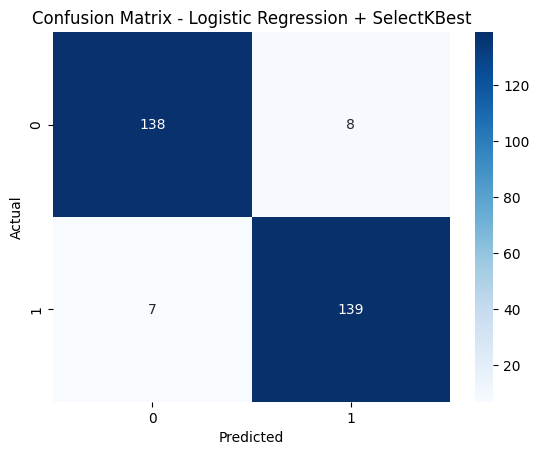


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       146
           1       0.95      0.95      0.95       146

    accuracy                           0.95       292
   macro avg       0.95      0.95      0.95       292
weighted avg       0.95      0.95      0.95       292



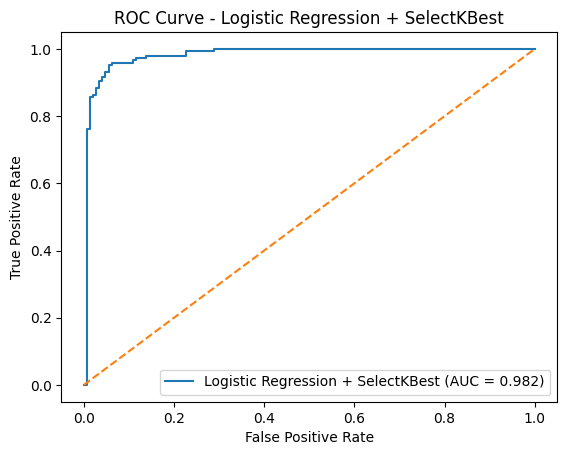


=== Logistic Regression + L1 SelectFromModel (Classification) ===
ROC AUC: 0.975
Confusion Matrix:
 [[137   9]
 [  9 137]]


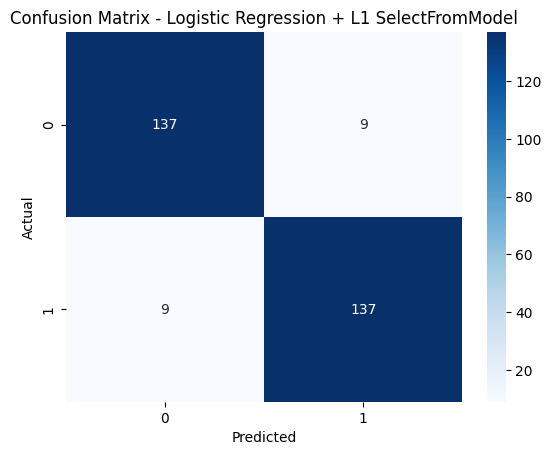


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       146
           1       0.94      0.94      0.94       146

    accuracy                           0.94       292
   macro avg       0.94      0.94      0.94       292
weighted avg       0.94      0.94      0.94       292



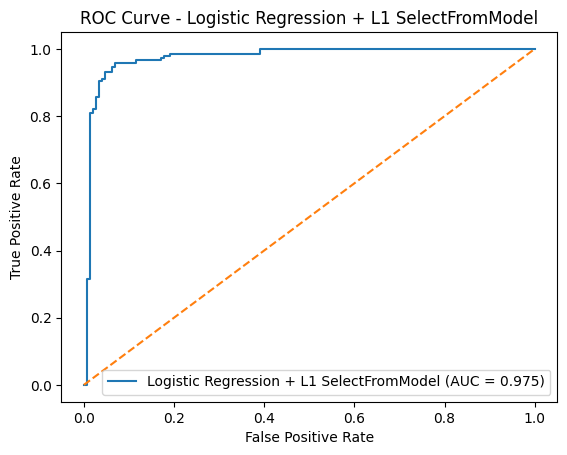

In [13]:
# %% [markdown]
# # 6. Logistic Regression Pipelines (Classification)
# 
# We build two pipelines:
# 
# 1. Preprocess → SelectKBest(f_classif) → LogisticRegression
# 2. Preprocess → SelectFromModel(L1-penalized LogisticRegression)

# %%
# --- Pipeline 1: SelectKBest (f_classif) ---
logreg_fs1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_select", SelectKBest(score_func=f_classif, k=50)),
    ("model", LogisticRegression(max_iter=1000))
])

# --- Pipeline 2: SelectFromModel (L1 LogisticRegression) ---
logreg_l1_estimator = LogisticRegression(
    penalty="l1",
    solver="liblinear",  # supports L1
    C=0.1,
    max_iter=1000
)

logreg_fs2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_select", SelectFromModel(estimator=logreg_l1_estimator, threshold="median")),
    ("model", LogisticRegression(max_iter=1000))
])

# Fit both models
logreg_fs1.fit(X_clf_train, y_clf_train)
logreg_fs2.fit(X_clf_train, y_clf_train)

# Evaluate both
evaluate_classification(logreg_fs1, X_clf_valid, y_clf_valid,
                        name="Logistic Regression + SelectKBest")
evaluate_classification(logreg_fs2, X_clf_valid, y_clf_valid,
                        name="Logistic Regression + L1 SelectFromModel")

/Users/kenbyrd/wgu/d789/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/kenbyrd/wgu/d789/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/kenbyrd/wgu/d789/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/kenbyrd/wgu/d789/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary 

=== MLPClassifier + SelectKBest(MI) (Classification) ===
ROC AUC: 0.264
Confusion Matrix:
 [[ 38 108]
 [ 96  50]]


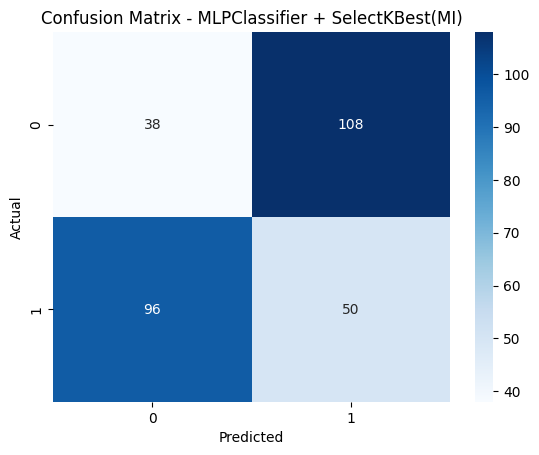


Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.26      0.27       146
           1       0.32      0.34      0.33       146

    accuracy                           0.30       292
   macro avg       0.30      0.30      0.30       292
weighted avg       0.30      0.30      0.30       292



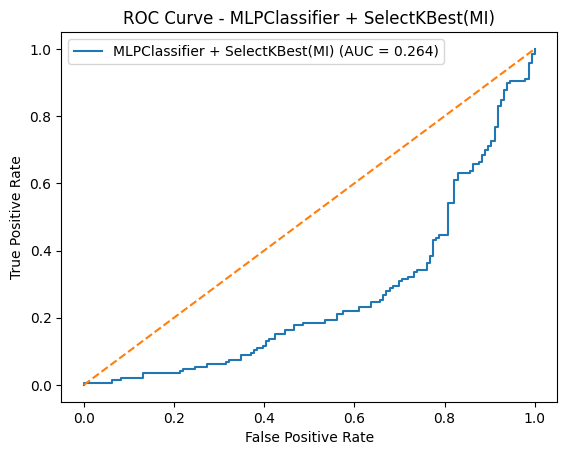


=== MLPClassifier + PCA (Classification) ===
ROC AUC: 0.976
Confusion Matrix:
 [[136  10]
 [ 13 133]]


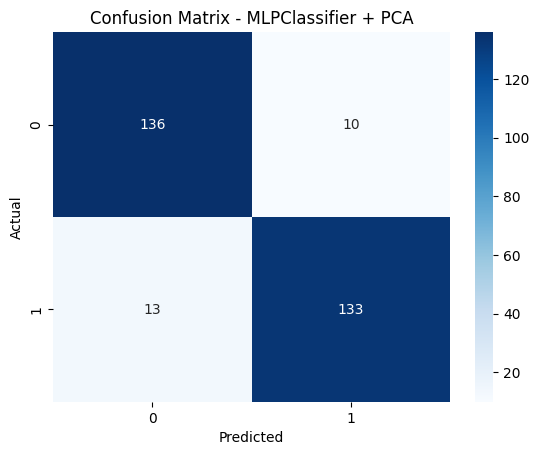


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       146
           1       0.93      0.91      0.92       146

    accuracy                           0.92       292
   macro avg       0.92      0.92      0.92       292
weighted avg       0.92      0.92      0.92       292



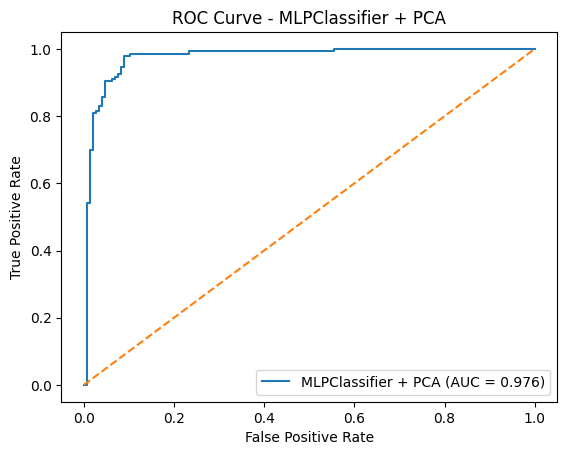

In [14]:
# %% [markdown]
# # 7. MLPClassifier Pipelines (Classification)
# 
# We build two pipelines:
# 
# 1. Preprocess → SelectKBest(mutual_info_classif) → MLPClassifier
# 2. Preprocess → PCA → MLPClassifier

# %%
# --- Common MLP configuration ---
mlp_base = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=200,
    random_state=42
)

# --- Pipeline 1: SelectKBest (mutual_info_classif) ---
mlp_fs1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_select", SelectKBest(score_func=mutual_info_classif, k=50)),
    ("model", mlp_base)
])

# --- Pipeline 2: PCA ---
# Note: PCA is applied after preprocessing, which outputs numeric features.
mlp_fs2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=50, random_state=42)),
    ("model", mlp_base)
])

# Fit both models
mlp_fs1.fit(X_clf_train, y_clf_train)
mlp_fs2.fit(X_clf_train, y_clf_train)

# Evaluate both
evaluate_classification(mlp_fs1, X_clf_valid, y_clf_valid,
                        name="MLPClassifier + SelectKBest(MI)")
evaluate_classification(mlp_fs2, X_clf_valid, y_clf_valid,
                        name="MLPClassifier + PCA")

In [15]:
# %% [markdown]
# # 8. TabNetClassifier Pipelines (Classification)
# 
# - Requires `pytorch-tabnet` package.
# - Pipelines:
#   1. Preprocess → VarianceThreshold → TabNetClassifier
#   2. Preprocess → SelectFromModel(RandomForestClassifier) → TabNetClassifier
#
# Uncomment the installation line below in your notebook environment if needed:
# !pip install pytorch-tabnet

# %%
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    tabnet_available = True
except ImportError:
    print("pytorch-tabnet not installed. Please run `pip install pytorch-tabnet` to use TabNet.")
    tabnet_available = False

# %%
if tabnet_available:
    # Base TabNet classifier configuration
    tabnet_base = TabNetClassifier(
        n_d=8, n_a=8,
        n_steps=3,
        gamma=1.3,
        n_independent=2,
        n_shared=2,
        seed=42,
        verbose=0
    )

    # --- Pipeline 1: VarianceThreshold ---
    tabnet_fs1 = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("var_thresh", VarianceThreshold(threshold=0.0)),  # drop zero-variance features
        ("model", tabnet_base)
    ])

    # --- Pipeline 2: SelectFromModel(RandomForestClassifier) ---
    rf_for_fs = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )

    tabnet_fs2 = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("feature_select", SelectFromModel(estimator=rf_for_fs, threshold="median")),
        ("model", tabnet_base)
    ])

    # Fit both models (TabNet expects numpy arrays; Pipeline handles conversion)
    tabnet_fs1.fit(X_clf_train.values, y_clf_train.values)
    tabnet_fs2.fit(X_clf_train.values, y_clf_train.values)

    # Evaluate both
    evaluate_classification(tabnet_fs1, X_clf_valid.values, y_clf_valid.values,
                            name="TabNet + VarianceThreshold")
    evaluate_classification(tabnet_fs2, X_clf_valid.values, y_clf_valid.values,
                            name="TabNet + RF SelectFromModel")

ValueError: Specifying the columns using strings is only supported for dataframes.

In [16]:
# %% [markdown]
# # 9. Example: Train Best Regression Model on Full Data and Predict on Test
# 
# Here we assume `linreg_fs2` was the best regression model.

# %%
# Refit on full regression data
linreg_fs2.fit(X, y_reg)

# Predict on test set
test_reg_preds = linreg_fs2.predict(X_test_full)

submission_reg = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": test_reg_preds
})

submission_reg.head()
# submission_reg.to_csv("submission_regression.csv", index=False)

/Users/kenbyrd/wgu/d789/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e+11, tolerance: 9.208e+08
  model = cd_fast.sparse_enet_coordinate_descent(


,Id,SalePrice
0,1461,109258.972932
1,1462,166057.155308
2,1463,184893.063303
3,1464,190644.715554
4,1465,208643.560763
